# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12, 14, 16) # small, medium, big

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

In [6]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [7]:
def split_vals(a, n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [9]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [10]:
set_rf_samples(50000)

In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20538495115059174, 0.2463770070315658, 0.911839902018488, 0.8915952469905479, 0.8948441803136404]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [12]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 1.39 s, sys: 32 ms, total: 1.42 s
Wall time: 1.43 s


(9.363183303035791, 0.29177819981067427)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [13]:
def get_preds(t): return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 100 ms, sys: 100 ms, total: 200 ms
Wall time: 786 ms


(9.363183303035791, 0.29177819981067427)

We can see that different trees are giving different estimates this auction. In order to see how prediction confidence varies, we can add this into our dataset.

You might remember from last lesson that one of the predictors we have is called `Enclosure` and this is an important one as we will see later. Let's start by doing a histogram.

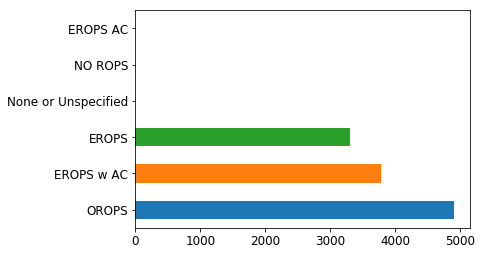

In [14]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [31]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842069,0.276354
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574116,0.262199
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686715,0.221762


We can already start to learn a little here:

- Prediction and the sale price are close to each other on average (good sign)
- Standard deviation varies a little bit

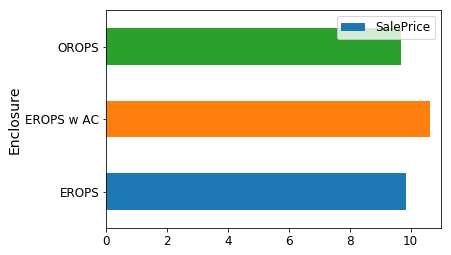

In [32]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0, 11))

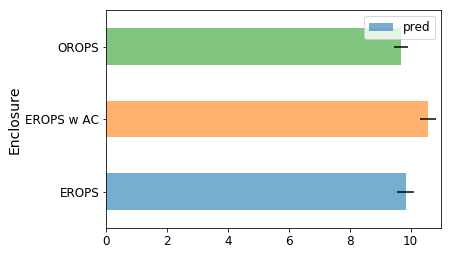

In [33]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0, 11))

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

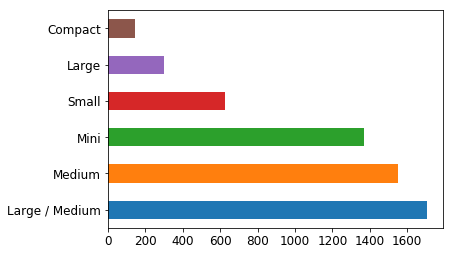

In [34]:
raw_valid.ProductSize.value_counts().plot.barh()

In [35]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.839529,0.328935
Large,10.470589,10.378042,0.348753
Large / Medium,10.691871,10.643605,0.295447
Medium,10.681511,10.622696,0.279759
Mini,9.535147,9.567031,0.255235
Small,10.324448,10.322267,0.313980


In [36]:
(summ.pred_std / summ.pred).sort_values(ascending=False)

ProductSize
Large             0.033605
Compact           0.033430
Small             0.030418
Large / Medium    0.027758
Mini              0.026679
Medium            0.026336
dtype: float64

What this tells us is that product size `Large` and `Compact` , our predictions are less accurate (relatively speaking as a ratio of the total price).

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [37]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.174338
13,ProductSize,0.100686
37,Coupler_System,0.085942
14,fiProductClassDesc,0.081841
38,Grouser_Tracks,0.072100
2,ModelID,0.051511
63,saleElapsed,0.049223
10,fiSecondaryDesc,0.047323
8,fiModelDesc,0.033645
19,Enclosure,0.031921


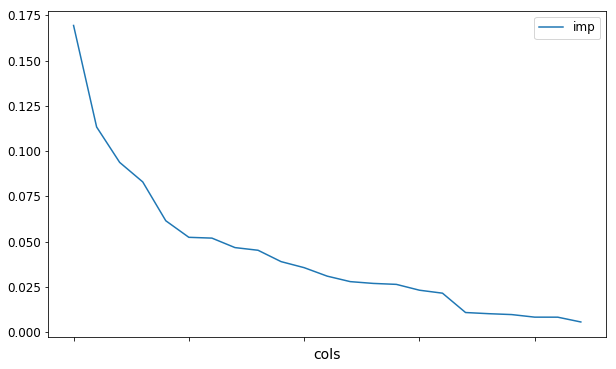

In [48]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [39]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

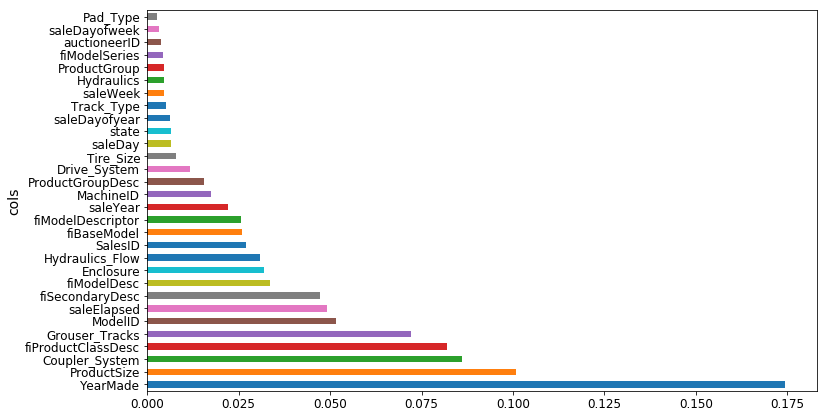

In [40]:
plot_fi(fi[:30])

In [41]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

23

In [43]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.208079761615792, 0.24826694225905, 0.9095112665835299, 0.8899257424863607, 0.8931178000447973]


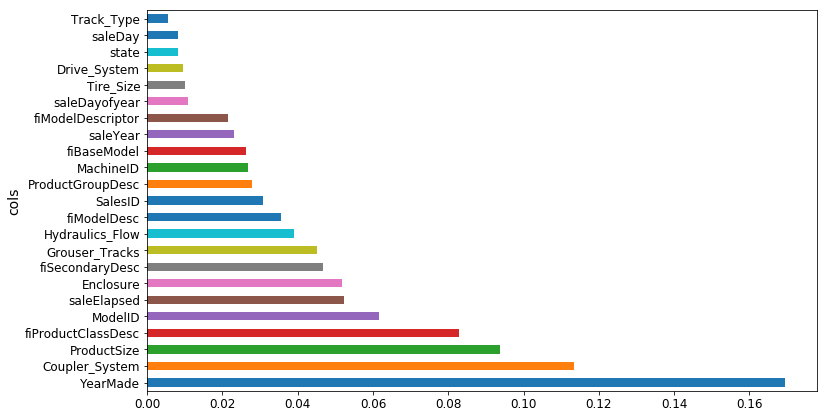

In [47]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

## One-hot encoding

So we can do one hot encoding easily enough and the way we do it is we pass one extra parameter to `proc_df` which is what is the max number of categories (`max_n_cat`). So if we say it's seven, then anything with less than seven levels is going to be turned into a one-hot encoded bunch of columns.

In [49]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20717305669201375, 0.25380058732731303, 0.910298155428778, 0.8849641463726011, 0.8925435801763005]


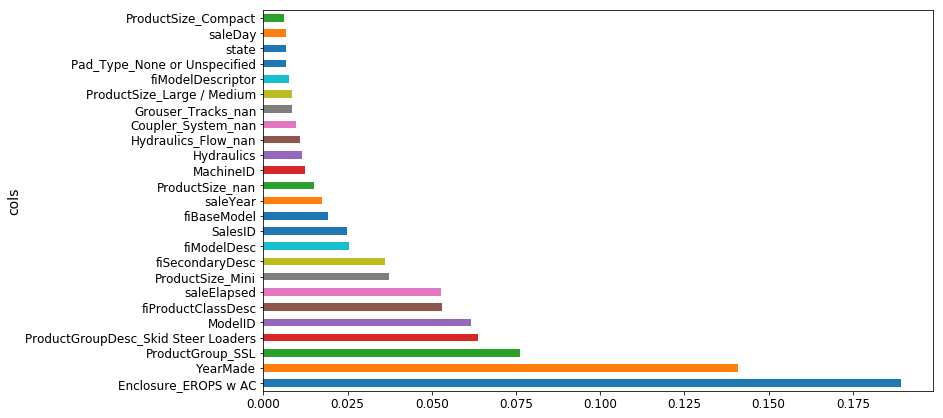

In [55]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25])

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [56]:
from scipy.cluster import hierarchy as hc

In [57]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)

In [58]:
# squareform -- convert distance matrix to a condensed one and vice versa
corr_condensed = hc.distance.squareform(1 - corr)

In [59]:
# Perform hierarchical/agglomerative clustering.
z = hc.linkage(corr_condensed, method='average')

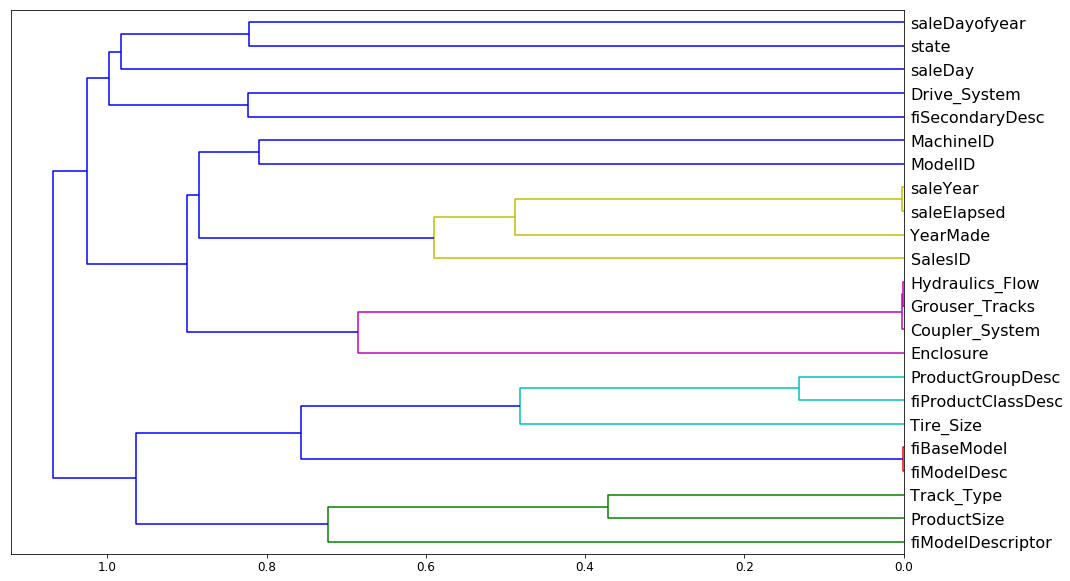

In [60]:
fig = plt.figure(figsize=(16, 10))

# Plot the hierarchical clustering as a dendrogram.
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [61]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, 
                              oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Basically what I'm going to do is try removing each one of these 9 or so variables one at a time and see which ones I can remove and it doesn't make the OOB score get worse.

Here's our baseline.

In [62]:
get_oob(df_keep)

0.8895460739978435

Now we try removing each variable one at a time.

In [63]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8894259423012607
saleElapsed 0.8871936070401353
fiModelDesc 0.8896152890022617
fiBaseModel 0.8893327741580571
Grouser_Tracks 0.8903083188152078
Coupler_System 0.890300099902578


It looks like we can try one from each group for removal. Let's see what that does.

In [64]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8892884223150683

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [65]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [66]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [67]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [68]:
reset_rf_samples()

In [69]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1,
                          oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1249901339021507, 0.22611753651998945, 0.967349766407941, 0.9086903948828916, 0.9090891455455712]


So I've now got a model which is smaller and simpler, and I'm getting a good score for. So at this point, I've now got rid of as many columns as I feel I comfortably can (ones that either didn't have a good feature importance or were highly related to other variables, and the model didn't get worse significantly when I removed them).

# Partial dependence

In [72]:
from pdpbox import pdp
from plotnine import *

In [73]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [74]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [77]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

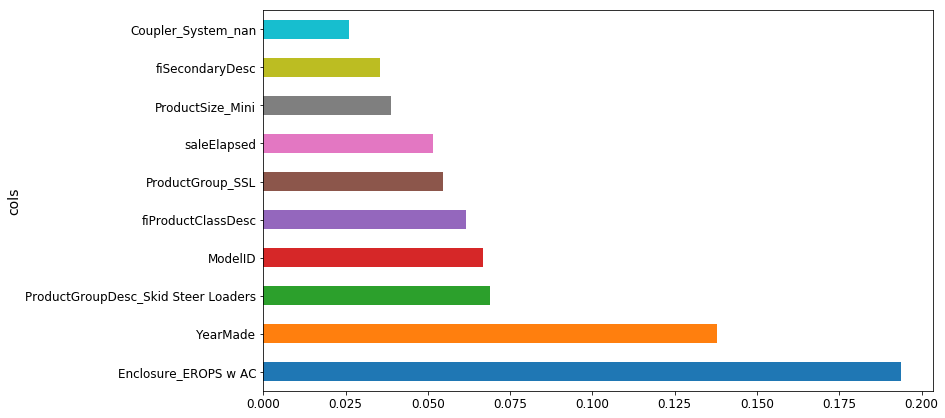

In [78]:
plot_fi(rf_feat_importance(m, df_trn2)[:10])

Let's try to learn more about those top 10. `YearMade` is the second most important. So one obvious thing we could do would be to plot `YearMade` against `saleElapsed` because as we've talked about already, it seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting `YearMade` against `saleElapsed` to see how they relate to each other.

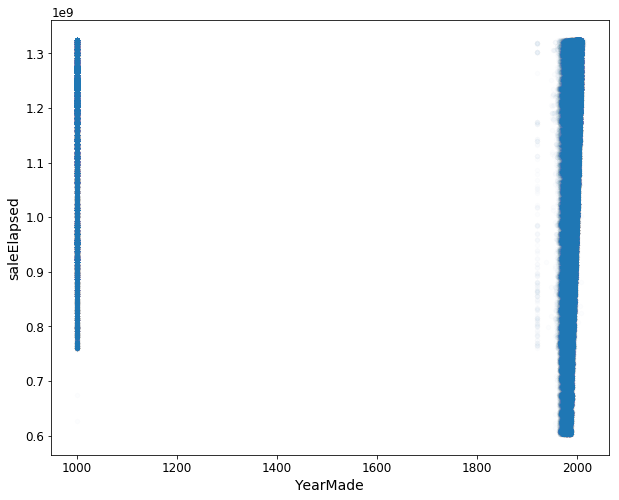

In [79]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10, 8))

In [80]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)

In [81]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

PlotnineError: "For loess smoothing, install 'scikit-misc'"

_Note: The previous error was due to missing Python package 'scikit-misc'. `pip install scikit-misc` will resolve this problem._

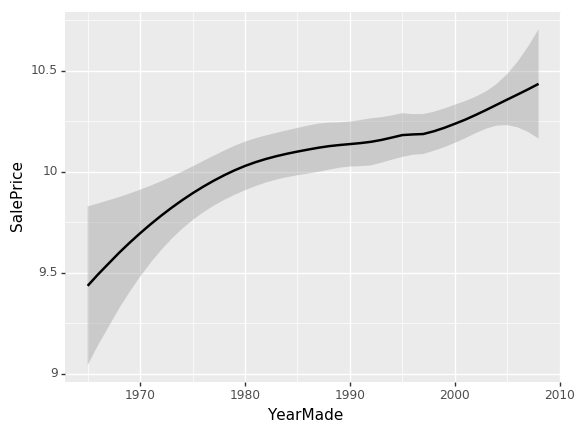

<ggplot: (-9223363272458941482)>

In [82]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

In [83]:
x = get_sample(X_train[X_train.YearMade > 1930], 500)

In [88]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [89]:
plot_pdp('YearMade')

TypeError: pdp_isolate() missing 1 required positional argument: 'model_features'

Fix for the previous error. The problem was due to PDPbox breaking API changes for `pdp_isolate`:

In [90]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, model_features=x.columns.values, feature=feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89eb2c54a8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89eac7eba8>})

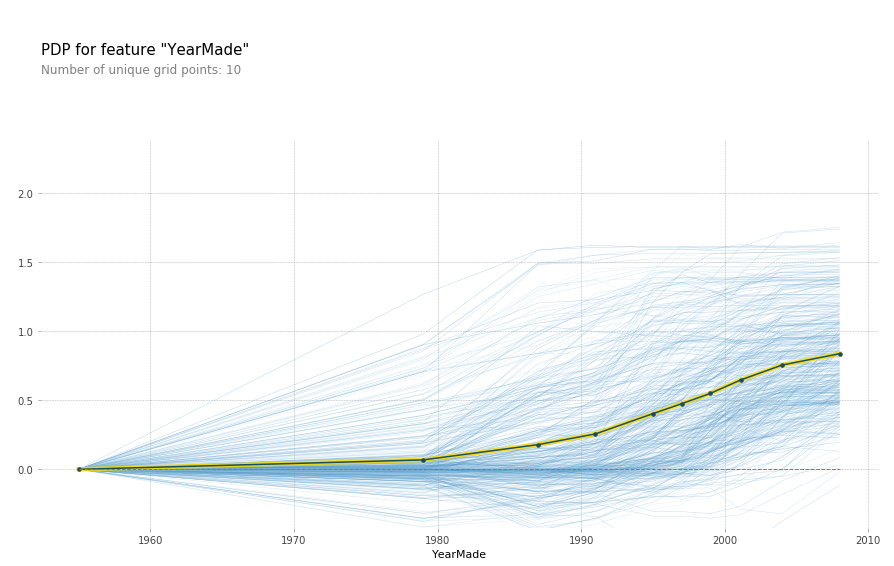

In [91]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89e79f4c18>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89e79dc4a8>})

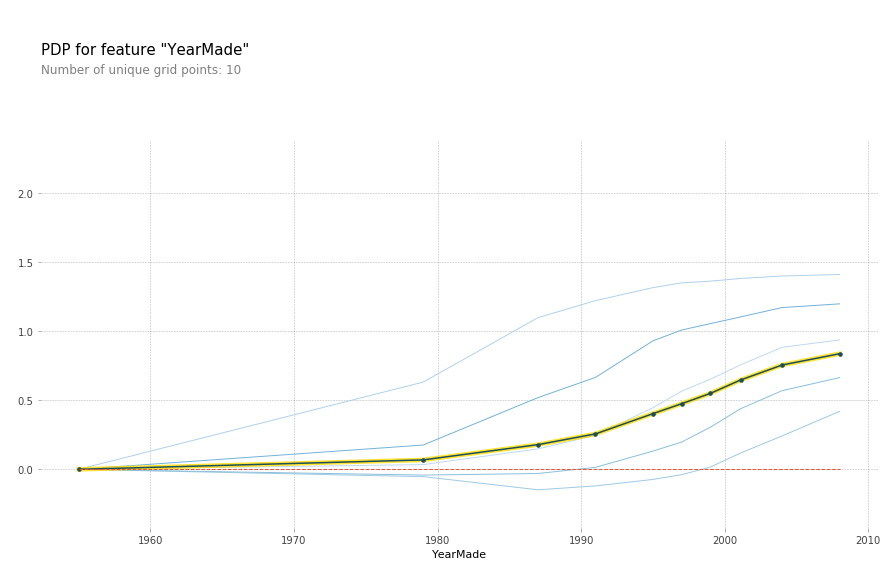

In [92]:
plot_pdp('YearMade', clusters=5)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89d3def438>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89d3d02d30>})

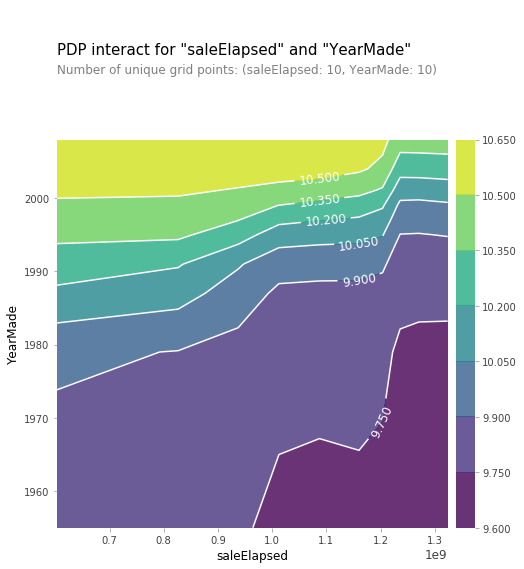

In [97]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, model_features=x.columns.values, features=feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89d4e95ba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89e7977438>})

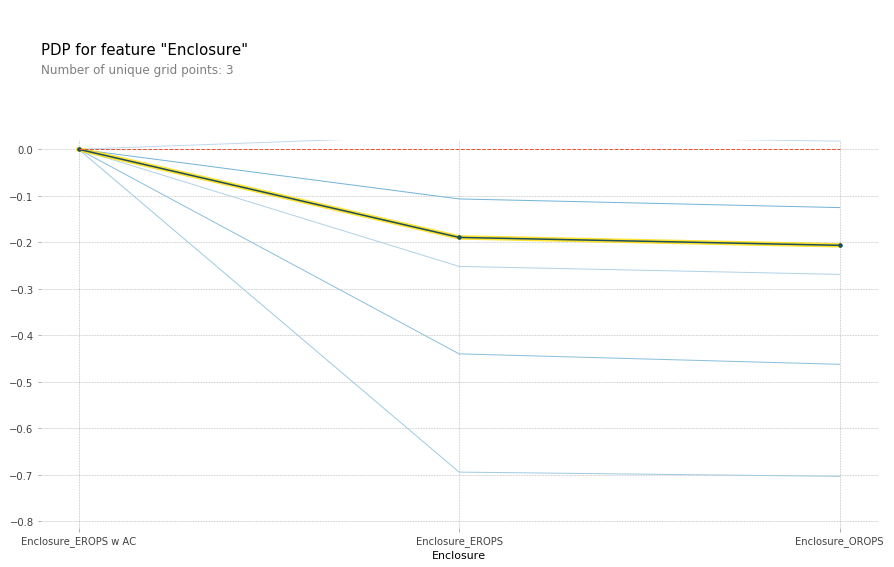

In [98]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

So it turns out that EROPS is enclosed rollover protective structure and so it turns out that if your bulldozer is fully enclosed then optionally you can also get air conditioning. So actually this thing is telling us whether it has air conditioning. If it's an open structure, then obviously you don't have air conditioning at all. So that's what these three levels are. So we've now learnt all other things being equal, the same bulldozer, sold at the same time, built at the same time, sold to the same person is going to be quite a bit more expensive if it has air conditioning than if it doesn't. So again, we are getting this nice interpretation ability. Now that I spent some time with this dataset, I'd certainly noticed that knowing this is the most important thing, you do notice that there is a lot more air conditioned bulldozers nowadays than they used to be and so there is definitely an interaction between date and that.

In [99]:
df_raw.YearMade[df_raw.YearMade < 1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear - df_raw.YearMade

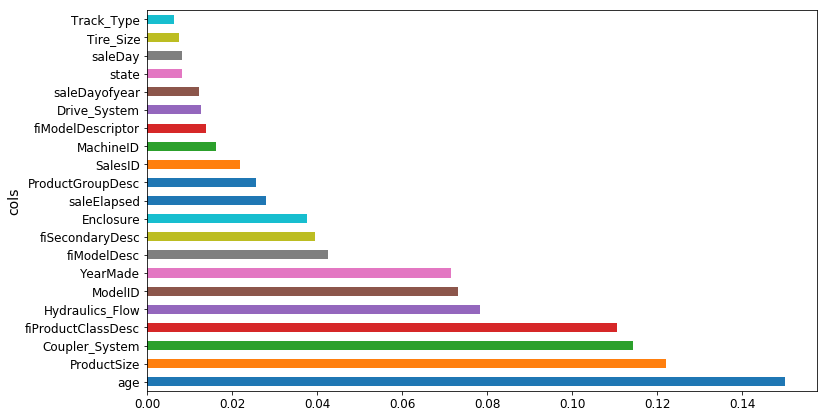

In [100]:
X_train, X_valid = split_vals(df_keep, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)

plot_fi(rf_feat_importance(m, df_keep))

Based on the earlier interaction analysis, I've tried, first of all, setting everything before 1950 to 1950 because it seems to be some kind of missing value. I've set `age` to be equal to `saleYear - YearMade`. Then I tried running a random forest on that. Indeed, `age` is now the single biggest thing, `saleElapsed` is way back down here, `YearMade` is back down here. So we've used this to find an interaction. But remember, of course a random forest can create an interaction through having multiple split points, so we shouldn't assume that this is actually going to be a better result. And in practice, I actually found when I looked at my score and my RMSE, adding `age` was actually a little worse. We will see about that later probably in the next lesson.

# Tree interpreter

In [101]:
from treeinterpreter import treeinterpreter as ti

ModuleNotFoundError: No module named 'treeinterpreter'

Solve previous problem of missing Python package:

In [102]:
!pip install treeinterpreter

  Running setup.py bdist_wheel for treeinterpreter ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/38/b1/6c/b387910dc2f824718afabe17190498a0bebdaae6472f0c9197
Successfully built treeinterpreter


In [103]:
from treeinterpreter import treeinterpreter as ti

In [104]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [106]:
row = X_valid.values[None, 0]
row

array([[      1999,          5,          0,         17,        665, 1284595200,          0,       3232,
                 1,          0,    4364751,          0,    2300944,          4,          0,          0,
                16,         35,        259,          2,         11]])

What I can do with a tree interpreter is I can go `ti.predict`, pass in my random forest and my row (so this would be like this particular customer's insurance information, or in this case this particular auction).

In [108]:
prediction, bias, contributions = ti.predict(m, row)

- `prediction`: The prediction from the random forest
- `bias`: The average sale price across the whole original dataset
- `contributions`: A column and the value to split by (i.e. the predictor), and how much it changed the predicted value.

In [115]:
prediction[0], bias[0]

(9.231699639046457, 10.105329762126551)

In [119]:
contributions.shape, contributions[0]

((1, 21),
 array([ 0.05454, -0.53493,  0.05262, -0.13532,  0.00327, -0.02299, -0.04472, -0.07966, -0.025  ,  0.03694,
        -0.01894, -0.0188 , -0.03356,  0.02874,  0.00293, -0.00284, -0.01383, -0.00774, -0.01455,  0.00643,
        -0.10622]))

In [120]:
# quick sort and returns the indices that would sort an array from smallest to largest
idxs = np.argsort(contributions[0])

In [123]:
idxs

array([ 1,  3, 20,  7,  6, 12,  8,  5, 10, 11, 18, 16, 17, 15, 14,  4, 19, 13,  9,  2,  0])

So here is all of our predictors and the value of each:

In [136]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5349329881380568),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1353165926856858),
 ('age', 11, -0.1062171213797185),
 ('fiModelDesc', 'KX1212', -0.07965666658046473),
 ('fiSecondaryDesc', nan, -0.044716864777594664),
 ('MachineID', 2300944, -0.033558327137111064),
 ('Enclosure', 'EROPS', -0.02500282446605051),
 ('saleElapsed', 1284595200, -0.022986709861900944),
 ('SalesID', 4364751, -0.018943775156163543),
 ('fiModelDescriptor', nan, -0.018797482606314597),
 ('saleDayofyear', 259, -0.014552929649122115),
 ('saleDay', 16, -0.013831410368159824),
 ('state', 'Ohio', -0.007741593495291887),
 ('Tire_Size', nan, -0.0028426164777370032),
 ('Drive_System', nan, 0.0029285970572123787),
 ('ModelID', 665, 0.003265544242171936),
 ('Track_Type', 'Steel', 0.006433144153453707),
 ('ProductGroupDesc', 'Track Excavators', 0.028738313863493393),
 ('Hydraulics_Flow', nan, 0.036944937750772545),
 ('Coupler_System', nan, 0.0526169987144

In [137]:
contributions[0].sum()

-0.8736301230800942

Random forests can be turned into a "white box", such that each prediction is decomposed into a sum of contributions from each feature i.e.

`prediction = bias + feature 1 contribution + … + feature n contribution`

[Source](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/)

In [141]:
pred = bias[0] + contributions[0].sum()
assert (pred == prediction[0]), "not the same"

Comments:
- So then there is this thing called `bias` and the bias is just the average before we start doing any splits.
- If you start with the average log of value and then we went down each tree and each time we saw `YearMade`, we had some impact, coupler system some impact, product size some impact, and so forth.